In [1]:
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

from utils.dataset import Dataset
from utils.utils import *

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
d = Dataset(path="Data/dataset_monthly.csv",
                date_col="Date",
                include_pct_change=True,
               )
d.data.describe()

,cpi_all_seas,cpi_all_unadj,cpi_energy_seas,cpi_energy_unadj,cpi_less_energy_seas,cpi_less_energy_unadj,empl_pop_ratio_seas,empl_pop_ratio_unadj,unempl_level_seas,unempl_level_unadj,...,VIX_pct_change,GSPC(S&P500)_pct_change,trade_balance_All_pct_change,trade_balance_Goods_pct_change,trade_balance_Services_pct_change,WTI_oil_price_pct_change,Perso_consumption_real_q_pct_change,Non_fin_non_corp_business_inv_pct_change,Non_fin_corp_business_inv_pct_change,Private_business_domestic_inv_pct_change
count,869.000000,869.000000,761.000000,761.000000,761.000000,761.000000,869.000000,869.000000,869.000000,869.000000,...,365.000000,869.000000,340.000000,340.000000,340.000000,869.000000,869.000000,869.000000,869.000000,723.000000
mean,112.165548,112.160533,105.268315,105.264729,127.272159,127.269214,59.250403,59.246605,6531.369390,6531.588032,...,0.022589,0.006991,0.020634,0.009458,0.006484,0.003977,0.005166,0.014271,0.016897,0.108575
std,78.128442,78.135807,72.568843,72.670914,77.295026,77.299044,2.755972,2.835482,3068.865101,3087.564460,...,0.225094,0.041932,0.173929,0.070373,0.066659,0.082877,0.008171,0.033270,0.028696,0.959358
min,23.500000,23.400000,21.300000,21.300000,28.400000,28.400000,51.300000,51.300000,1596.000000,1480.000000,...,-0.396151,-0.217817,-0.589832,-0.235778,-0.250081,-0.433413,-0.034546,-0.093944,-0.095692,-1.050137
25%,32.080000,32.000000,27.800000,27.700000,43.900000,44.000000,57.000000,57.000000,3957.000000,3942.000000,...,-0.119190,-0.017195,-0.046326,-0.030411,-0.017715,-0.001348,0.001429,-0.000305,0.000000,-0.061693
50%,102.900000,102.600000,100.600000,100.100000,123.700000,123.800000,58.700000,58.800000,6599.000000,6576.000000,...,-0.006855,0.009552,0.013111,0.007932,0.006942,0.000000,0.005270,0.015310,0.018247,0.019589
75%,179.300000,179.800000,151.500000,154.100000,194.700000,194.500000,61.900000,61.900000,8196.000000,8169.000000,...,0.102158,0.034211,0.069497,0.050265,0.029271,0.020026,0.008956,0.031957,0.031921,0.108027
max,259.050000,258.678000,271.149000,280.833000,265.539000,265.896000,64.700000,64.900000,23078.000000,22504.000000,...,1.483268,0.163047,2.178099,0.316025,0.341811,1.345708,0.046877,0.204685,0.201437,11.148098


In [3]:
Y_cols = ["Fed_rate_month_avg", "Fed_rate_spot_EOM",
         "Fed_rate_month_avg_diff", "Fed_rate_month_avg_pct_change",
         "Fed_rate_month_avg_diff_3_class", "Fed_rate_month_avg_diff_5_class",
         "Fed_rate_month_avg_diff_9_class", "Fed_rate_month_avg_trend"
         ]
X_non_cols = ["Fed_rate_month_avg_diff_3_class", "Fed_rate_month_avg_diff_5_class",
              "Fed_rate_month_avg_diff_9_class", "Fed_rate_month_avg_trend"
             ]
X_cols = list(filter(lambda x: x not in X_non_cols, d.data.columns))

excl_cols = list(filter(lambda x: x.replace("_pct_change", "")[-5:] == "unadj", X_cols))
X_cols = list(filter(lambda x: x not in excl_cols, X_cols))

In [4]:
d.drop(excl_cols, inplace=True)
features_info = open_file("./config/features_info.yaml")

## Data visualization

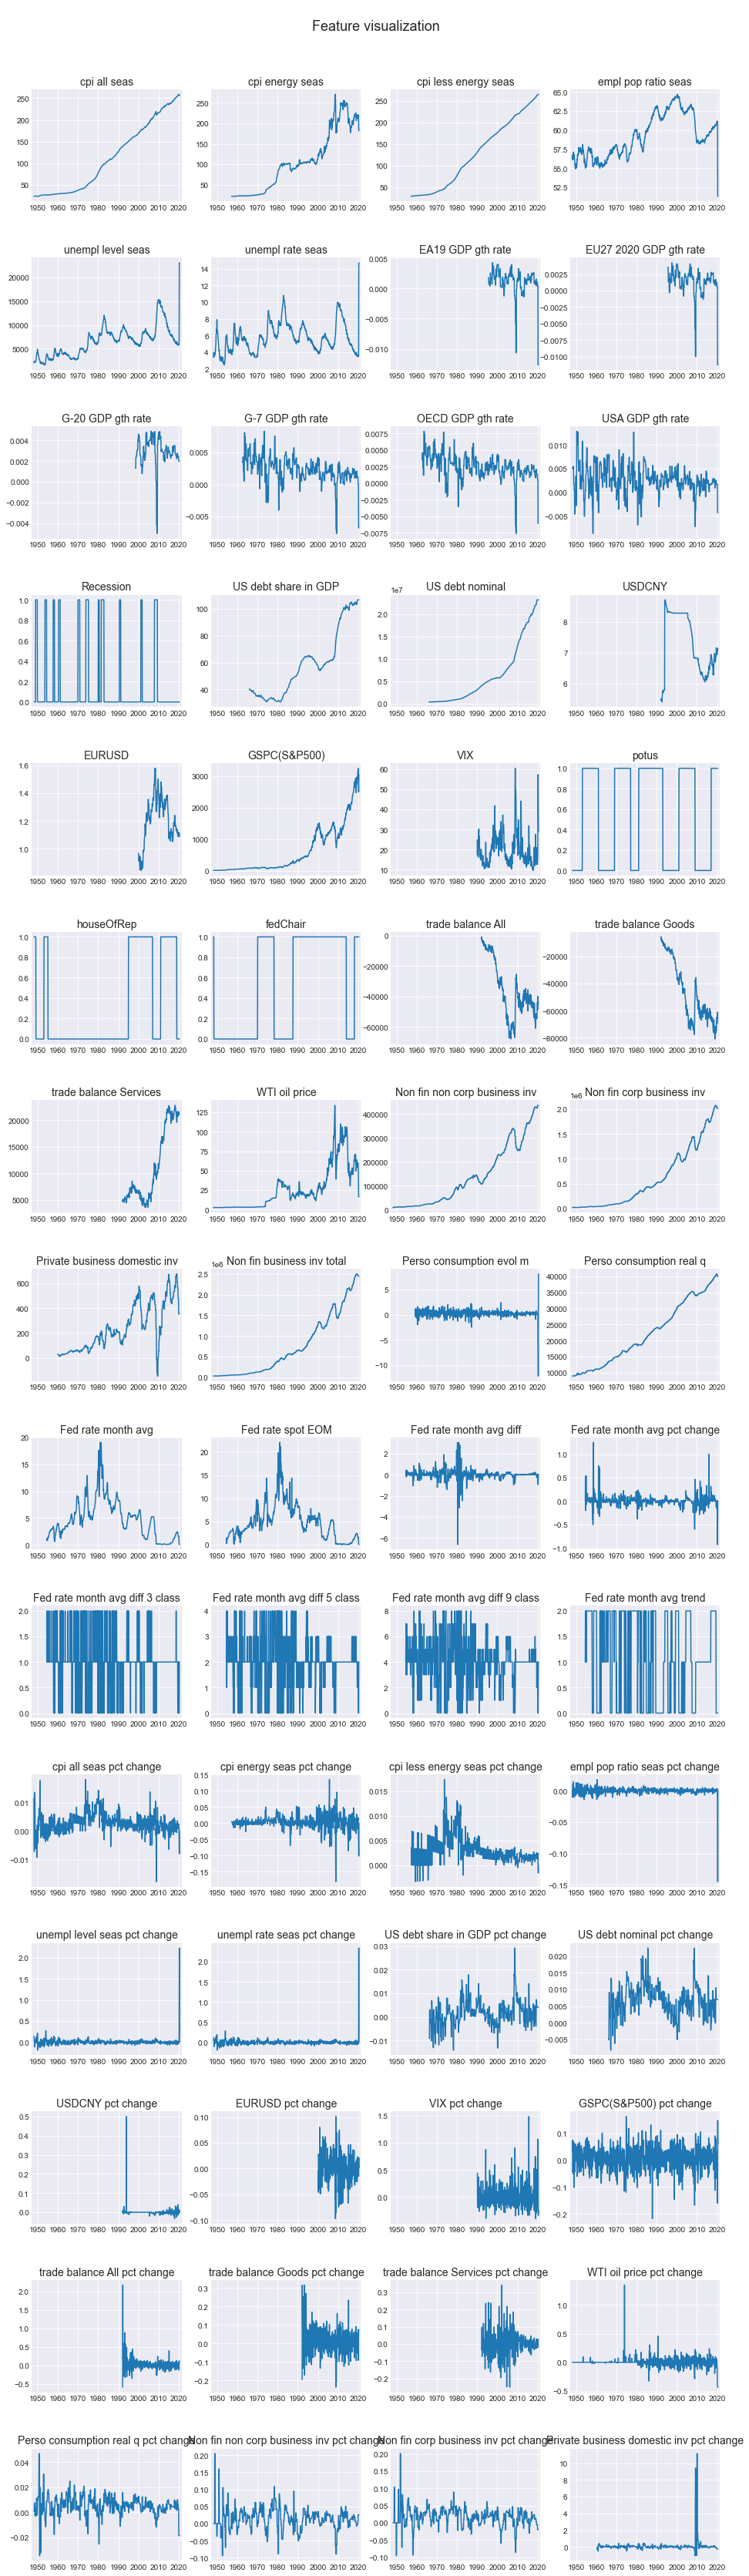

In [5]:
d.visualize_features(ncols=4,
                     height_per_ax=3
                    )

## Feature selection

### 1. Feature stationarity

#### Dickey-Fuller test to ensure stationarity of variables

https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/a

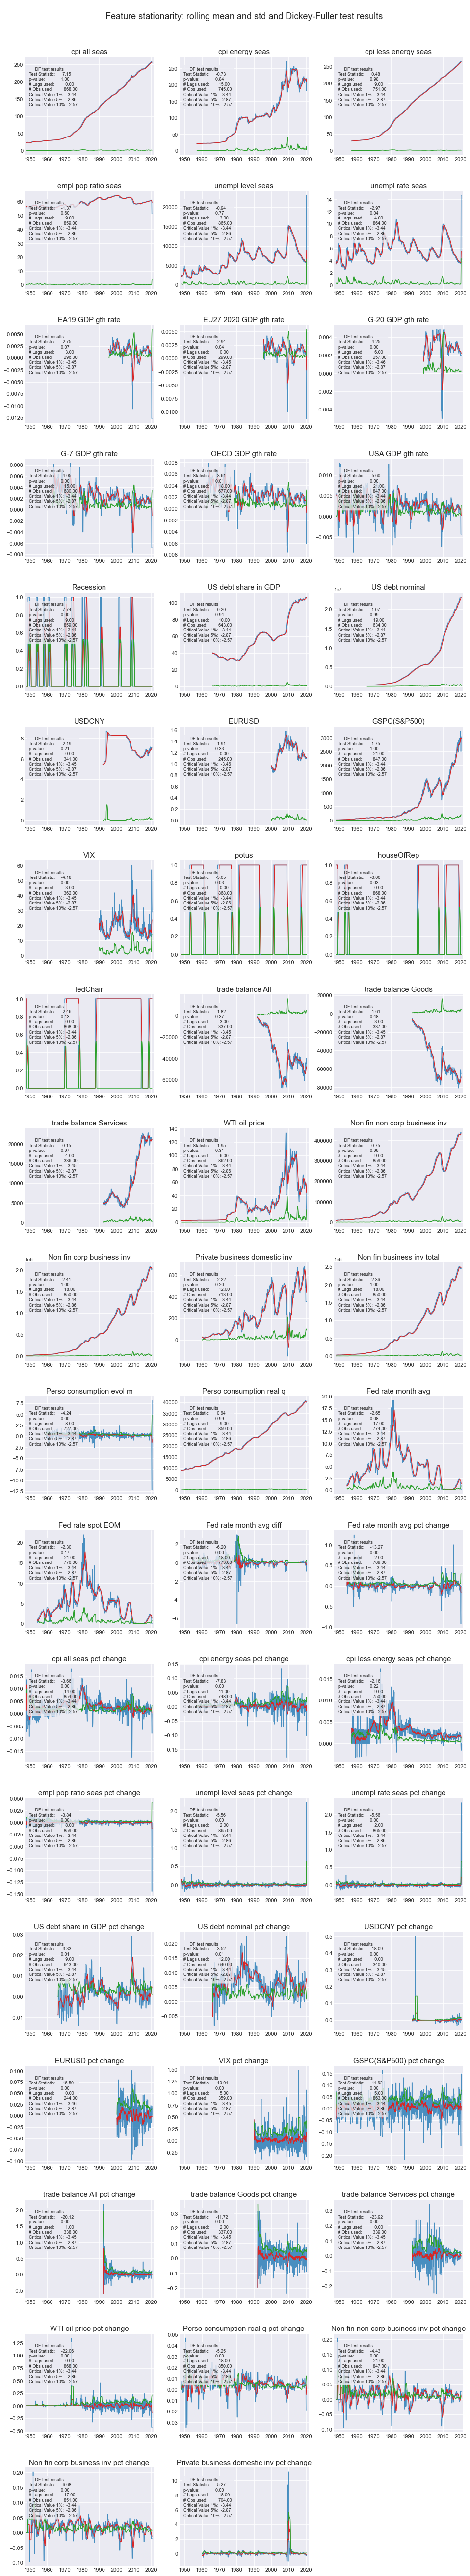

In [6]:
stat_results = d.test_stationarity(columns=X_cols,
                                   plot_test_results=True,
                                   ncols=3,
                                   height_per_ax=4,
                                  )

#### Take only stationary features, keep only one of original feature and "_pct_change"

In [7]:
_ = d.remove_non_stationary_features(stat_results,
                                     stat_conf_level="5%",
                                     excl_cols=Y_cols
                                    )

------------------------------------- Non-stationarity: following features dropped -------------------------------------
cpi_all_seas
cpi_energy_seas
cpi_less_energy_seas
empl_pop_ratio_seas
unempl_level_seas
EA19_GDP_gth_rate
US_debt_share_in_GDP
US_debt_nominal
USDCNY
EURUSD
GSPC(S&P500)
fedChair
trade_balance_All
trade_balance_Goods
trade_balance_Services
WTI_oil_price
Non_fin_non_corp_business_inv
Non_fin_corp_business_inv
Private_business_domestic_inv
Non_fin_business_inv_total
Perso_consumption_real_q
cpi_less_energy_seas_pct_change


### 2. Feature seasonality

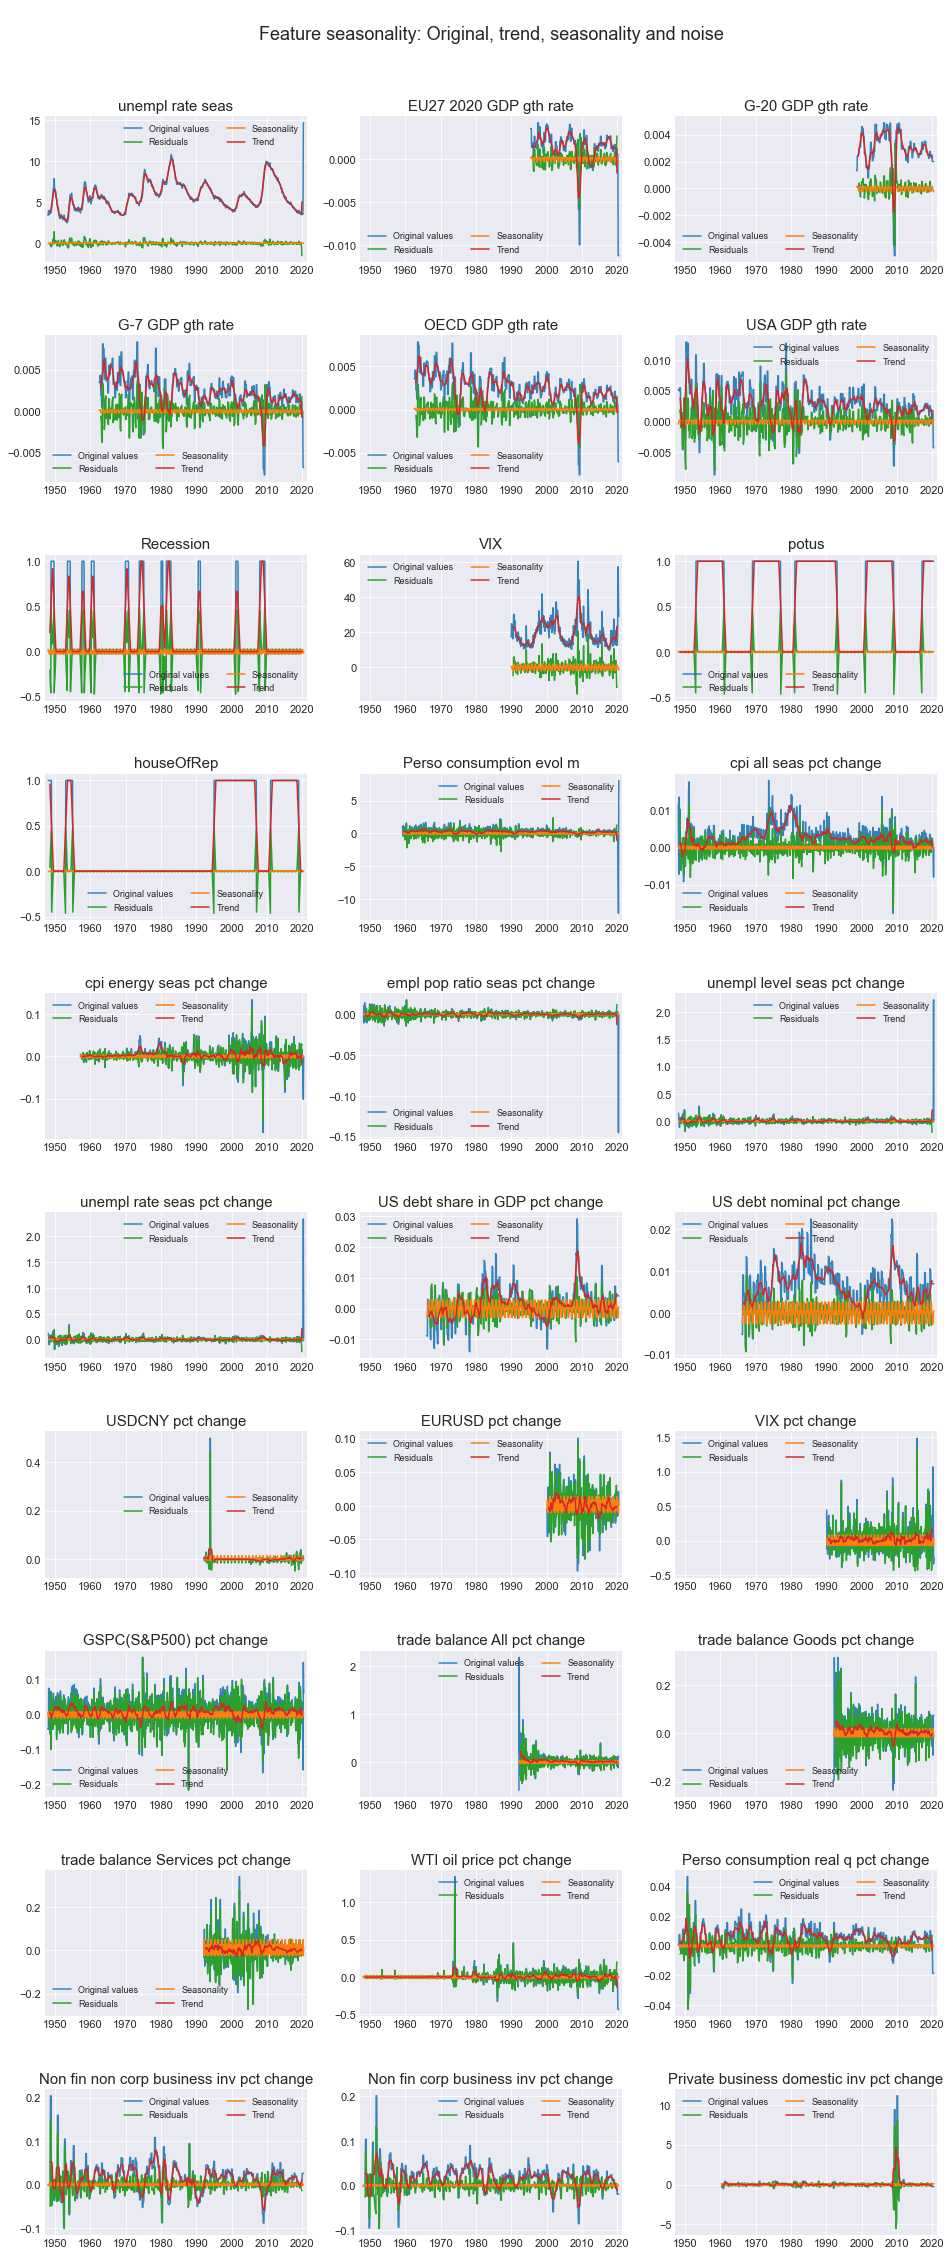

In [8]:
X_trend, X_seas, X_resid = d.test_seasonality(excl_cols=Y_cols,
                                              plot_graphs=True,
                                              ncols=3,
                                              height_per_ax=3
                                             )

In [9]:
_ = d.remove_seasonality(X_seas, threshold = 0.15)     

----------------------------------- Seasonality removed from the following features ------------------------------------
VIX
Perso_consumption_evol_m
cpi_energy_seas_pct_change
US_debt_share_in_GDP_pct_change
US_debt_nominal_pct_change
USDCNY_pct_change
EURUSD_pct_change
VIX_pct_change
GSPC(S&P500)_pct_change
trade_balance_Goods_pct_change
trade_balance_Services_pct_change
WTI_oil_price_pct_change


### 3. Add lagged features

In [10]:
d.shift_features(row_shifts=(1, 2, 3, 6, 12), inplace=True)
# Boolean features were converted to weird type, let's convert them back to booleans
d.data.loc[:, d.data.dtypes == 'O'] = d.data.loc[:, d.data.dtypes == 'O'].astype(bool)

### 4. Choosing start date and end date of the dataset

In [11]:
start_date = dt.datetime(1992, 1, 1)
end_date = dt.datetime(2020, 5, 1)
d.del_rows(start_date=start_date, end_date=end_date, inplace=True)
d.data = d.data.dropna(axis=1)  # dropping columns with nans
X_cols = [
    x 
    for x in d.data.columns 
    if (
        x not in Y_cols 
        and len(x.split("_t-")) == 2
    )
]
d.data.head()

,Date,unempl_rate_seas,G-7_GDP_gth_rate,OECD_GDP_gth_rate,USA_GDP_gth_rate,Recession,VIX,potus,houseOfRep,Perso_consumption_evol_m,...,Non_fin_corp_business_inv_pct_change_t-1,Non_fin_corp_business_inv_pct_change_t-2,Non_fin_corp_business_inv_pct_change_t-3,Non_fin_corp_business_inv_pct_change_t-6,Non_fin_corp_business_inv_pct_change_t-12,Private_business_domestic_inv_pct_change_t-1,Private_business_domestic_inv_pct_change_t-2,Private_business_domestic_inv_pct_change_t-3,Private_business_domestic_inv_pct_change_t-6,Private_business_domestic_inv_pct_change_t-12
528,1992-01-31,7.3,0.001908,0.002108,0.001160,0.0,17.179427,True,False,1.577935,...,0.003983,-0.000910,-0.000910,-0.006661,-0.004287,-0.260950,0.190165,0.190165,0.062278,-0.155053
529,1992-02-29,7.4,0.001908,0.002108,0.001160,0.0,17.176023,True,False,0.126407,...,0.003983,0.003983,-0.000910,-0.006661,-0.004287,-0.260950,-0.260950,0.190165,0.062278,-0.155053
530,1992-03-31,7.4,0.002655,0.002903,0.003974,0.0,17.013234,True,False,0.127240,...,0.003983,0.003983,0.003983,-0.000910,-0.002533,-0.260950,-0.260950,-0.260950,0.190165,-0.101173
531,1992-04-30,7.4,0.002655,0.002903,0.003974,0.0,16.378363,True,False,0.142240,...,0.032212,0.003983,0.003983,-0.000910,-0.002533,0.400075,-0.260950,-0.260950,0.190165,-0.101173
532,1992-05-31,7.6,0.002655,0.002903,0.003974,0.0,15.476309,True,False,0.519602,...,0.032212,0.032212,0.003983,-0.000910,-0.002533,0.400075,0.400075,-0.260950,0.190165,-0.101173


### 5. Feature correlation

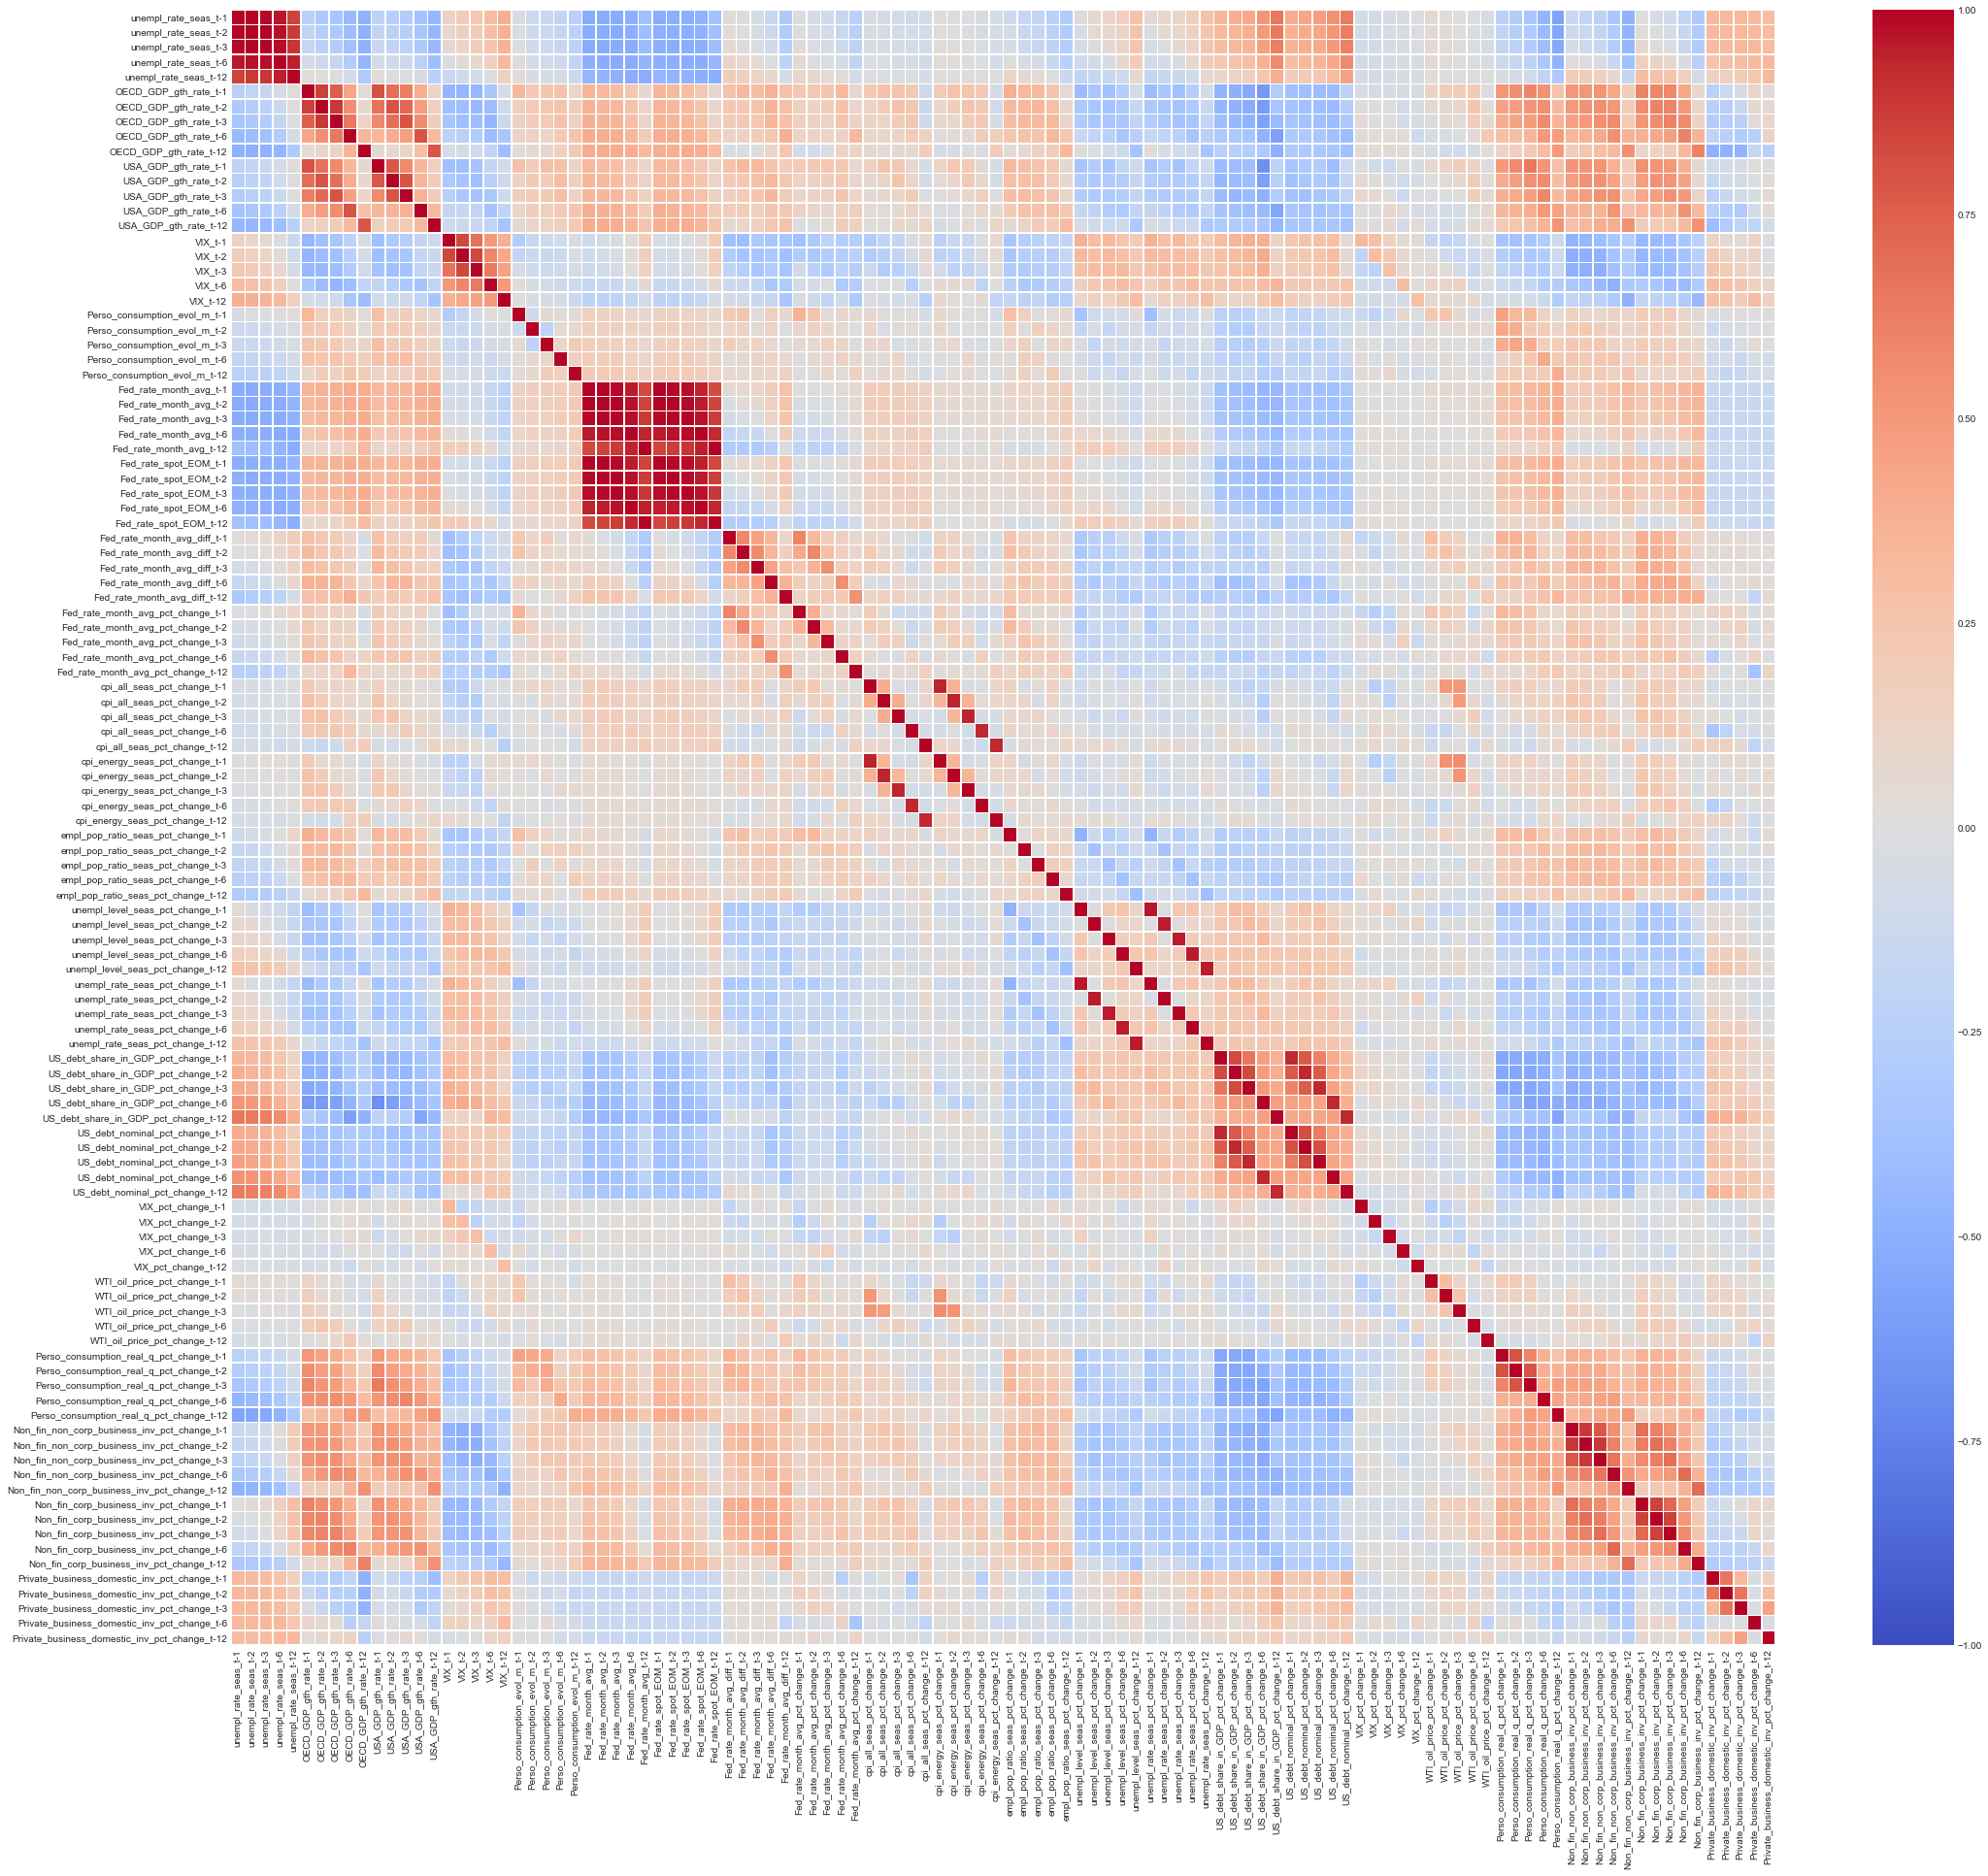

In [12]:
fig = plt.figure(figsize = (0.23 * len(X_cols), 0.2 * len(X_cols)))
num_cols = [x for x in X_cols if x.split("_t-")[0] in features_info["numeric features"]]
heat_map = sns.heatmap(d.data[num_cols].corr(), cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)

### 6. Split in train and test set and save

In [13]:
test_size=.25
X_cols=[x for x in d.data.columns if "_t-" in x]

X_train, Y_train, X_test, Y_test = d.train_test_split_dates(
    X_cols=X_cols,
    Y_cols=Y_cols,
    test_size=test_size,
    standardize=True
)

In [14]:
path = "./Models/start_{:s}_end_{:s}_test_{:s}/".format(
    start_date.strftime("%Y%m"),
    end_date.strftime("%Y%m"),
    X_test['Date'].iloc[0].strftime("%Y%m")
)
d.save_dataset(path=path, 
               X_train=X_train,
               Y_train=Y_train, 
               X_test=X_test, 
               Y_test=Y_test, 
               replace=True
              )

--------------------- 5 file(s) saved succesfully in ./Models/start_199201_end_202005_test_201304/ ---------------------
